In [375]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [376]:
data = pd.read_csv("sampled_2.5k.csv") #Unbalanced Finance dataset, Balanced Financed dataset, Balanced Larger/Reddit dataset - 1000 each, 2000 each
data.head()

,Sentence,Sentiment
0,Fun fact: The mass buying of puts can create a...,positive
1,Well I guess those TSLA are not gonna print. I...,positive
2,In fact todays price drop is great for the ave...,positive
3,TSLA holding 700 like its defending Rome,positive
4,Outlook on TSLA is good imho but it’s the orig...,positive


In [377]:
data.Sentiment.value_counts()

positive    2500
negative    2500
Name: Sentiment, dtype: int64

In [378]:
#Assumption that the data has been preprocessed and the neutral labeled samples has been taken out
#data = data[data.Sentiment != "neutral"]

In [379]:
pos_count, neg_count = data['Sentiment'].value_counts()

In [380]:
#Assumption that the data is balanced/has been preprocessed
#Undersampling data
#pos_data = data[data['Sentiment'] == 'positive']
#neg_data = data[data['Sentiment'] == 'negative']

#pos_under = pos_data.sample(neg_count)
#data = pd.concat([pos_under, neg_data], axis=0)
#data.Sentiment.value_counts()

In [381]:
num_of_categories = 45000

shuffled = data.reindex(np.random.permutation(data.index))
positive = shuffled[shuffled['Sentiment'] == 'positive'][:num_of_categories]
negative = shuffled[shuffled['Sentiment'] == 'negative'][:num_of_categories]
concated = pd.concat([positive, negative], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['Label'] = 0

In [382]:
#One-hot encode the lab
concated.loc[concated['Sentiment'] == 'positive', 'Label'] = 0
concated.loc[concated['Sentiment'] == 'negative', 'Label'] = 1
print(concated['Label'][:10])

labels = to_categorical(concated['Label'], num_classes = 2)

if 'Sentiment' in concated.keys():
    concated.drop(['Sentiment'], axis=1)
'''
 [1. 0.] positive
 [0. 1.] negative
'''

2175    0
3014    1
4449    1
3635    1
3213    1
3418    1
678     0
2758    1
3315    1
2215    0
Name: Label, dtype: int64


'\n [1. 0.] positive\n [0. 1.] negative\n'

In [383]:
n_most_common_words = 50000
max_len = 128

tokenizer = Tokenizer(num_words = n_most_common_words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(concated['Sentence'].values)
sequences = tokenizer.texts_to_sequences(concated['Sentence'].values)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen = max_len)

Found 32987 unique tokens.


In [384]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size = 0.20, random_state = 42, stratify = data["Sentiment"])

In [385]:
#Hyperparameters
epochs = 25
emb_dim = 128
batch_size = 100
lstm_out = 175 # 100, 128, 150

#Dropout Values
#Activation Function - sigmoid, softmax

In [386]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((4000, 128), (4000, 2), (1000, 128), (1000, 2))


In [387]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(lstm_out, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(2, activation='sigmoid')) #softmax
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 128, 128)          6400000   
                                                                 
 spatial_dropout1d_18 (Spati  (None, 128, 128)         0         
 alDropout1D)                                                    
                                                                 
 lstm_18 (LSTM)              (None, 175)               212800    
                                                                 
 dense_18 (Dense)            (None, 2)                 352       
                                                                 
Total params: 6,613,152
Trainable params: 6,613,152
Non-trainable params: 0
_________________________________________________________________
None


In [388]:
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.2)
#history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/25
32/32 [==============================] - 23s 647ms/step - loss: 0.6639 - acc: 0.5809 - val_loss: 0.6534 - val_acc: 0.6012
Epoch 2/25
32/32 [==============================] - 20s 624ms/step - loss: 0.6226 - acc: 0.6469 - val_loss: 0.6291 - val_acc: 0.6375
Epoch 3/25
32/32 [==============================] - 20s 626ms/step - loss: 0.5875 - acc: 0.6862 - val_loss: 0.6189 - val_acc: 0.6675
Epoch 4/25
32/32 [==============================] - 21s 641ms/step - loss: 0.5609 - acc: 0.7097 - val_loss: 0.6231 - val_acc: 0.6725
Epoch 5/25
32/32 [==============================] - 21s 641ms/step - loss: 0.5067 - acc: 0.7581 - val_loss: 0.6034 - val_acc: 0.7025
Epoch 6/25
32/32 [==============================] - 21s 643ms/step - loss: 0.4459 - acc: 0.7997 - val_loss: 0.5945 - val_acc: 0.7138
Epoch 7/25
32/32 [==============================] - 21s 659ms/step - loss: 0.4074 - acc: 0.8247 - val_loss: 0.6211 - val_acc: 0.7163
Epoch 8/25
32/32 [==============================] - 21s 661ms/step - 

In [389]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 2s 51ms/step - loss: 0.7801 - acc: 0.7320
Test set
  Loss: 0.780
  Accuracy: 0.732


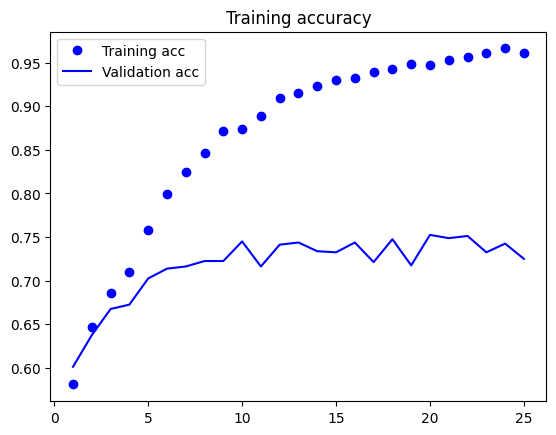

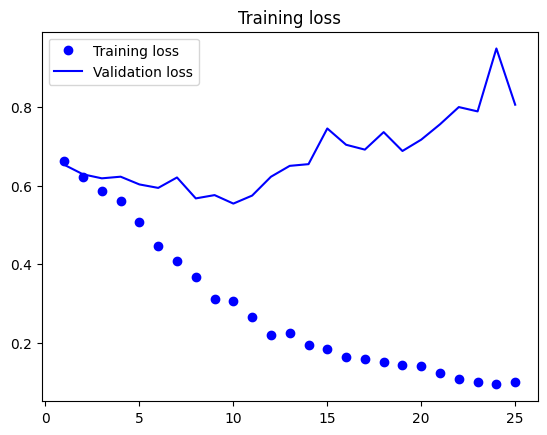

In [390]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [391]:
test_sent = ['Bro, I have been waiting for you for so long!']

#vectorizing the tweet by the pre-fitted tokenizer instance
test_sent = tokenizer.texts_to_sequences(test_sent)

#padding the tweet to have exactly the same shape as `embedding_2` input
test_sent = pad_sequences(test_sent, maxlen = max_len, dtype = 'int32', value = 0)

sentiment = model.predict(test_sent)

print("Actual output of model: ", sentiment)

if(np.argmax(sentiment) == 0):
    print("Sentence 1 has a positive sentiment.")
elif (np.argmax(sentiment) == 1):
    print("Sentence 1 has a negative sentiment")

1/1 [==============================] - 0s 274ms/step
Actual output of model:  [[0.09797909 0.9108989 ]]
Sentence 1 has a negative sentiment


In [392]:
test_sent2 = ['The stocks are going down. Everything is low!']
test_sent2 = tokenizer.texts_to_sequences(test_sent2)
test_sent2 = pad_sequences(test_sent2, maxlen = 128, dtype = 'int32', value = 0)
sentiment2 = model.predict(test_sent2)

print("Actual output of model: ", sentiment2)

if(np.argmax(sentiment2) == 0):
    print("Sentence 2 has a positive sentiment.")
elif (np.argmax(sentiment2) == 1):
    print("Sentence 2 has a negative sentiment")

1/1 [==============================] - 0s 41ms/step
Actual output of model:  [[0.0434215 0.9615644]]
Sentence 2 has a negative sentiment


In [393]:
test = pd.read_csv('test_50.csv')
test.head()

,Sentence,Sentiment
0,The TSLA dump will be legendary. I'm definitel...,positive
1,Dumped my 4/29 TSLA puts but kept everything f...,positive
2,OP that 2021 scenario is highly skewed\n\nFirs...,positive
3,I suppose you could technically think of it th...,positive
4,All today showed is market is irrational.\n\nT...,positive


In [397]:
#test = test[test.Sentiment != "neutral"] # Data is preprocessed

test = test.sample(frac = 1)

sentence = test['Sentence'].tolist()
sentiment = test['Sentiment'].tolist()

test_size = len(sentence)

In [398]:
i = 0
correct = 0
ar_actual = []
ar_predicted = []

for i in range(test_size):
    test = sentence[i]
    test = tokenizer.texts_to_sequences(test)
    test = pad_sequences(test, maxlen = max_len, dtype = 'int32', value = 0)
    sentiment_t = model.predict(test)[0]
    
    actual = sentiment[i]
    
    if(np.argmax(sentiment_t) == 0):
        predicted = "negative"
    elif (np.argmax(sentiment_t) == 1):
        predicted = "positive"
    
    ar_actual.append(actual)
    ar_predicted.append(actual)
    
    if(predicted == actual):
        correct += 1
    
    print(i)

1/1 [==============================] - 0s 60ms/step
0
16/16 [==============================] - 1s 39ms/step
1
18/18 [==============================] - 1s 40ms/step
2
1/1 [==============================] - 0s 50ms/step
3
4/4 [==============================] - 0s 40ms/step
4
2/2 [==============================] - 0s 31ms/step
5
3/3 [==============================] - 0s 40ms/step
6
3/3 [==============================] - 0s 34ms/step
7
2/2 [==============================] - 0s 30ms/step
8
2/2 [==============================] - 0s 36ms/step
9
3/3 [==============================] - 0s 45ms/step
10
4/4 [==============================] - 0s 40ms/step
11
3/3 [==============================] - 0s 34ms/step
12
296/296 [==============================] - 12s 41ms/step
13
2/2 [==============================] - 0s 31ms/step
14
129/129 [==============================] - 5s 40ms/step
15
310/310 [==============================] - 12s 39ms/step
16
14/14 [==============================] - 1s 38ms/step
17


In [ ]:
print("Number of correct predictions: ", correct)
print("Total predictions made: ", len(sentence))

Number of correct predictions:  25
Total predictions made:  50
